In [1]:
import os, yaml, time
import matplotlib.pyplot as plt
import pandas as pd
import torch
from src.data_utils import *
from src.denoising_utils import *
from src.unet_model import Unet3D
from src.residuals_nematic import ResidualsNematic
import pathlib
from tqdm import tqdm

In [2]:
# Specify the path to your directory containing the model folders 
# directory_path = pathlib.Path('D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\train result\\PIDM-Nematics-V1-model\\trained_models\\run_1')
directory_path = pathlib.Path('D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\PIDM-Nematics-V3\\trained_models\\run_cond2')
name = 'model'
load_model_step = 5000

os.chdir(directory_path)
os.getcwd()

'D:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\PIDM-Nematics-V3\\trained_models\\run_cond2'

In [3]:


no_samples = 3 # number of samples to generate
create_gif = True # create GIFs of denoising process for visualization (may take some time)
# test_batches = -1 # set to -1 for full evaluation of both test sets

load_path = os.path.join(directory_path)
config = yaml.safe_load(Path(load_path, 'model', 'model.yaml').read_text())

In [4]:
# diffusion parameters
if config['x0_estimation'] == 'mean':
    use_ddim_x0 = False
elif config['x0_estimation'] == 'sample':
    use_ddim_x0 = True
ddim_steps = config['ddim_steps']
residual_grad_guidance = config['residual_grad_guidance'] 


# diffusion model params
gov_eqs = config['gov_eqs']
if gov_eqs != 'Nematic' and residual_grad_guidance:
    raise ValueError('Gradient guidance only implemented for Darcy equation.')
fd_acc = config['fd_acc']
diff_steps = config['diff_steps']
use_dynamic_threshold = False
self_condition = False
use_double = False

save_output = True
eval_residuals = True

data_paths = None
if gov_eqs == 'Nematic':
    input_dim = 2
    output_dim = 2
    pixels_at_boundary = True
    domain_length = 1.
    reverse_d1 = False
    bcs = 'none' # 'none', 'periodic'
    pixels_per_dim = 64
    train_batch_size = 32
    if name == 'local_test':
        no_samples = 1
        train_batch_size = 8
    sigmoid_last_channel = False
else:
    raise ValueError('Unknown governing equations.')
    
output_save_dir = load_path + '/evaluation'
# check if output dir exists, if yes iterate name, e.g. evaluation_1, evaluation_2, ...
if os.path.exists(output_save_dir):
    i = 1
    while os.path.exists(output_save_dir + f'_{i}/'):
        i += 1
    output_save_dir += f'_{i}/'
os.makedirs(output_save_dir, exist_ok=True)

if use_double:
    torch.set_default_dtype(torch.float64)

In [5]:

diffusion_utils = DenoisingDiffusion(diff_steps, device, residual_grad_guidance)

if gov_eqs == 'Nematic':
    model = Unet3D(dim = 32, channels = output_dim, sigmoid_last_channel = sigmoid_last_channel).to(device)

load_model(Path(load_path, 'model', 'checkpoint_' + str(load_model_step) + '.pt'), model)

if gov_eqs == 'Nematic':
    residuals = ResidualsNematic(model = model, fd_acc = fd_acc, pixels_per_dim = pixels_per_dim, pixels_at_boundary = pixels_at_boundary, reverse_d1 = None, device = device, bcs = bcs, domain_length =1, residual_grad_guidance = residual_grad_guidance, use_ddim_x0 = use_ddim_x0, ddim_steps = ddim_steps)
else:
    raise ValueError('Unknown residuals mode.')

# count number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')

# generate sample based on validation set
if gov_eqs == 'Nematic':
    conditioning_input = None
    sample_shape = (no_samples, output_dim, pixels_per_dim, pixels_per_dim)


Checkpoint loaded from D:\diffusion model\TEST4\denoising-diffusion-flax-20250107T081638Z-001\PIDM-Nematics-V3\trained_models\run_cond2\model\checkpoint_5000.pt
Number of trainable parameters: 10386482


Using model to generate Q tensor field

In [7]:
N1 = 64
N2 = 64
# make this as for loop
icx_list = []
icy_list = []
R_list = []
anchoring_type_list = []
inclusion_list = []
anchoring_direction_list = []
Mask_input = torch.zeros((no_samples, 2, N1, N2))
for i in range(no_samples):
    icx = N1/2 + np.random.randint(-10, 10)
    icy = N2/2 + np.random.randint(-10, 10)
    R = np.random.randint(8, 12)
    anchoring_type = np.random.randint(1, 5)
    inclusion = np.random.choice([True, False])
    anchoring_direction = 2*np.pi*np.random.rand()
    mask = diffusion_utils.generate_mask(N1, N2, icx, icy, R, anchoring_type, inclusion, anchoring_direction)
    # plt.figure()
    # plt.imshow(mask[:,:,1], cmap='gray')
    # print(mask[:,:,1])
    # print((np.squeeze(mask[0,:,:]).shape))
    # print(mask[1,:,:])
    # plt.figure(figsize=(10, 10))
    print(f'icx: {icx}, icy: {icy}, R: {R}, anchoring_type: {anchoring_type}, inclusion: {inclusion}, anchoring_direction: {anchoring_direction}')
    # plt.imshow((mask[1,:,:]), cmap='gray')
    icx_list.append(icx)
    icy_list.append(icy)
    R_list.append(R)
    anchoring_type_list.append(anchoring_type)
    inclusion_list.append(inclusion)
    anchoring_direction_list.append(anchoring_direction)
    Mask_input[i] = torch.tensor(mask)  # 显式指定设备
print(Mask_input.shape)


icx: 24.0, icy: 32.0, R: 8, anchoring_type: 4, inclusion: False, anchoring_direction: 2.7411167442621904
icx: 23.0, icy: 26.0, R: 8, anchoring_type: 2, inclusion: True, anchoring_direction: 0.6004103908107759
icx: 25.0, icy: 24.0, R: 11, anchoring_type: 1, inclusion: False, anchoring_direction: 1.3423001175424918
torch.Size([3, 2, 64, 64])


In [8]:
output = diffusion_utils.p_sample_loop(conditioning_input, Mask_input, sample_shape, 
                        save_output=save_output, surpress_noise=True, 
                        use_dynamic_threshold=use_dynamic_threshold, 
                        residual_func=residuals, eval_residuals = eval_residuals)


Save figure

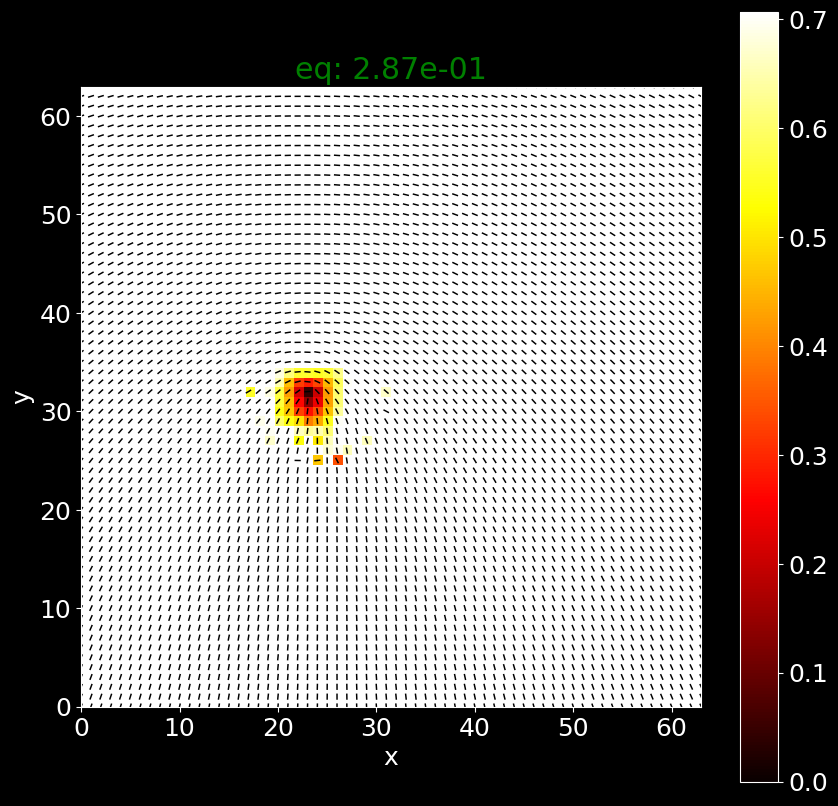

<Figure size 640x480 with 0 Axes>

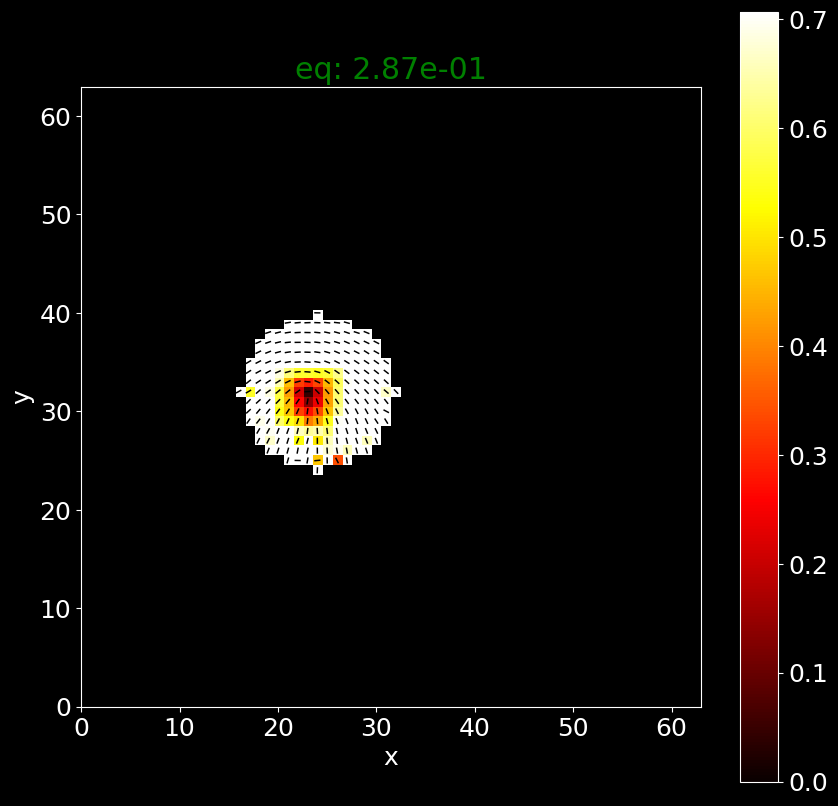

100%|██████████| 101/101 [00:27<00:00,  3.69it/s]
C:\Users\52577\AppData\Local\Temp\ipykernel_2376\3765831342.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))


<Figure size 640x480 with 0 Axes>

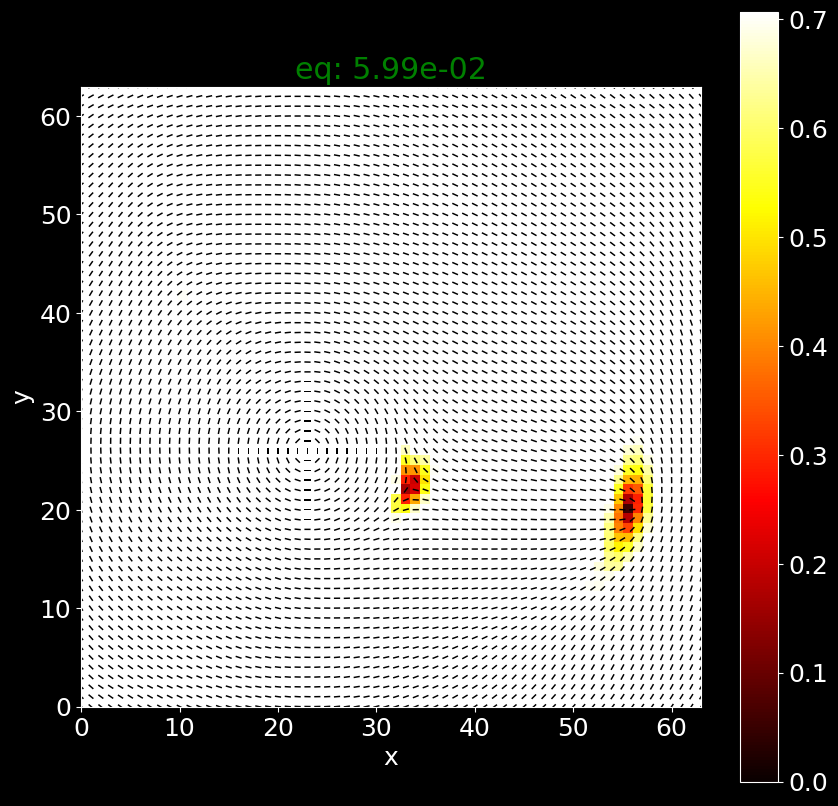

<Figure size 640x480 with 0 Axes>

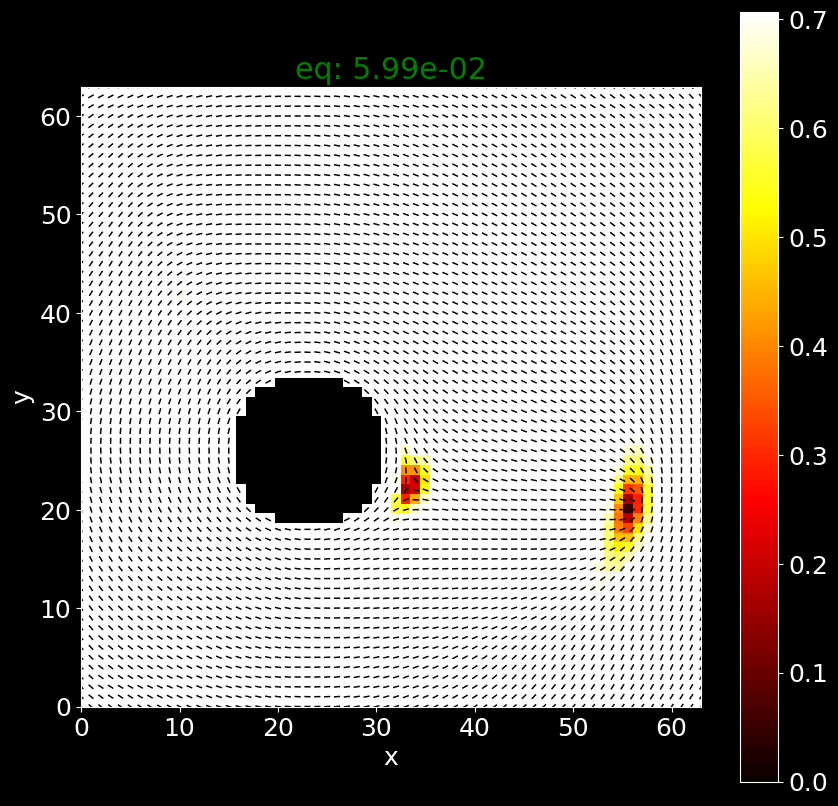

100%|██████████| 101/101 [00:27<00:00,  3.70it/s]


<Figure size 640x480 with 0 Axes>

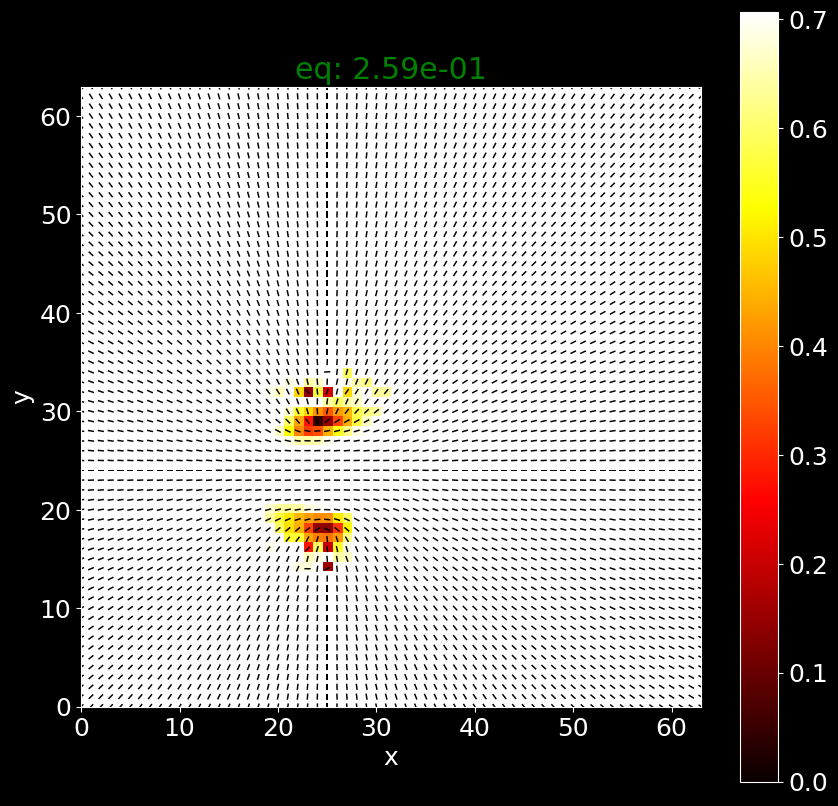

<Figure size 640x480 with 0 Axes>

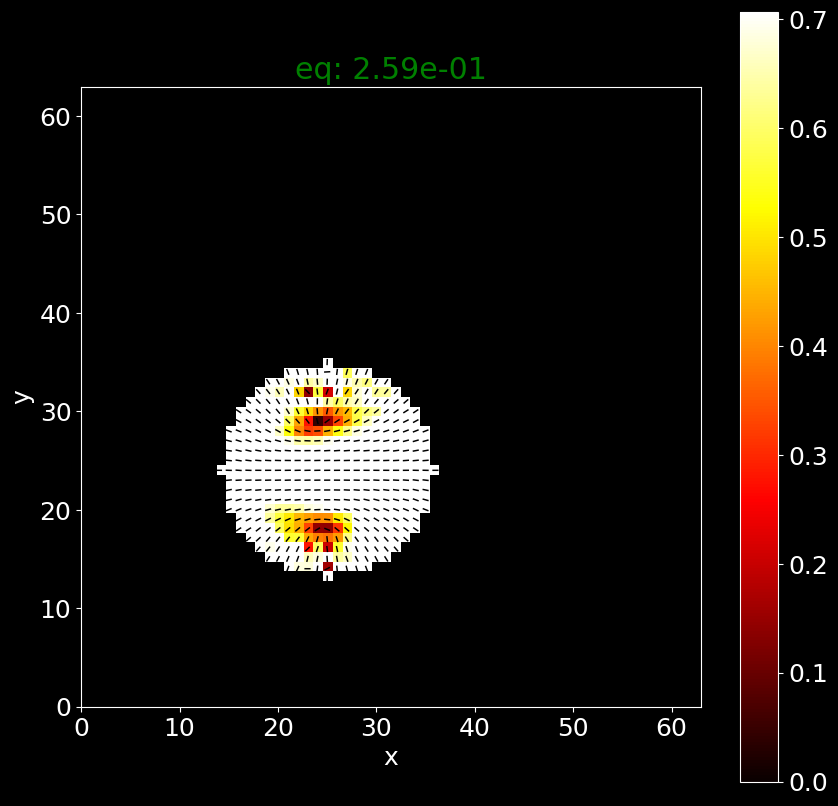

100%|██████████| 101/101 [00:25<00:00,  3.98it/s]


<Figure size 640x480 with 0 Axes>

In [9]:

if eval_residuals:
    seqs = output[0]
    residual = output[1]['residual']
    residual = residual.abs().mean(dim=tuple(range(1, residual.ndim))) # reduce to batch dim
else:
    seqs = output
    
output_save_dir_validation = output_save_dir + f'/validation/step_{load_model_step}/'
os.makedirs(output_save_dir_validation, exist_ok=True)


labels = ['sample', 'model_output']
for seq_idx, seq in enumerate(seqs):

    # NOTE: We here only evaluate the sample at the final timestep and skip model_output as this is identical (since no noise is applied in last step).
    if seq_idx == 1:
        continue

    # remove frame dimension
    seq = torch.stack(seq, dim=0)
    if len(seq.shape) == 6:
        seq = seq.squeeze(-3)
        
    last_preds = seq[-1].numpy()
    sel_samples = np.arange(no_samples)
    channels = np.arange(output_dim)

    for sel_sample in sel_samples:
        last_pred = last_preds[sel_sample, :]
        last_pred_temp = rearrange(last_pred, 'c h w -> h w c')
        Qxx = last_pred_temp[:,:,0]
        Qxy = last_pred_temp[:,:,1]
        Azi = Mask_input[sel_sample,0,:,:]
        Seq = np.sqrt(2)/2
        Azi_Qxx = Seq * np.cos(2*Azi)
        Azi_Qxy = Seq * np.sin(2*Azi)
        Qxx = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxx, Qxx)
        Qxy = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxy, Qxy)
        N2, N1 = Qxx.shape
        nx = np.zeros((N2,N1))
        ny = np.zeros((N2,N1))
        S = np.zeros((N2,N1))
        x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
        for i in range(N2):
            for j in range(N1):
                matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                [Qxy[i, j], -Qxx[i, j]]])
                vals, vecs = np.linalg.eigh(matrix)
                index = np.argmax(vals)
                nx[i,j] = vecs[0, index]
                ny[i,j] = vecs[1, index]
                S[i,j] = vals[index]*2
        # plt.figure(figsize=(10, 10))
        # S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
        # nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
        # ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = labels[seq_idx] + '_sample_' + str(sel_sample)  + '.png'
        plt.show()
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
        nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
        ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')
        ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
        if eval_residuals:
            title = f'eq: {residual[sel_sample]:.2e}'
            plt.title(title, color='green')
        filename = labels[seq_idx] + '_sample_' + str(sel_sample)  + '.png'
        plt.show()
        plt.savefig(output_save_dir_validation + filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        os.makedirs(output_save_dir_validation + f'/sample_{sel_sample}/', exist_ok=True)
        for sel_channel in channels:
            np.savetxt(output_save_dir_validation + f'/sample_{sel_sample}/' + labels[seq_idx] + '_' + str(sel_channel) + '.csv', last_pred[sel_channel], delimiter=',')

        # create_gif = False
        if create_gif:
            os.makedirs(output_save_dir_validation + '/gif/', exist_ok=True)
            Q = rearrange(seq[:,sel_sample,:,:], 't c h w -> t h w c')
            Q.detach().cpu().numpy()
            Q = Q.numpy()
            for frame_t in tqdm(range(0,Q.shape[0],10)):
                Qxx = Q[frame_t,:,:,0]
                Qxy = Q[frame_t,:,:,1]
                N2, N1 = Qxx.shape[1], Qxx.shape[0]
                nx = np.zeros((N2,N1))
                ny = np.zeros((N2,N1))
                S = np.zeros((N2,N1))
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                for i in range(N2):
                    for j in range(N1):
                        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                        [Qxy[i, j], -Qxx[i, j]]])
                        vals, vecs = np.linalg.eigh(matrix)
                        index = np.argmax(vals)
                        nx[i,j] = vecs[0, index]
                        ny[i,j] = vecs[1, index]
                        S[i,j] = vals[index]*2
                S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
                nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
                ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
                fig, ax = plt.subplots(figsize=(10, 10))
                im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
                plt.colorbar(im)
                plt.xlabel('x')
                plt.ylabel('y')
                ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
                plt.title('t = ' + str(frame_t), color='green')
                filename = str(sel_sample)+'_sample_' + str(frame_t)  + '.png'
                plt.savefig(output_save_dir_validation+'/gif/' + filename, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
            # load this image to create gif
            images = []
            for i in range(0,Q.shape[0],10):
                images.append(imageio.imread(output_save_dir_validation+'/gif/'+ str(sel_sample) + '_sample_' + str(i)  + '.png'))
            imageio.mimsave(output_save_dir_validation+'/gif/' + labels[seq_idx] + '_sample_' + str(sel_sample)  + '.gif', images)


if eval_residuals:
    residuals_array = residual.detach().cpu().numpy()

    df_data = {'Sample Index': list(range(no_samples)),
            'Residuals (abs)': list(residuals_array)}
        
    df = pd.DataFrame(df_data)
    csv_path = os.path.join(output_save_dir_validation, 'sample_statistics.csv')
    df.to_csv(csv_path, index=False)



In [9]:
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))
x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2

icx: 30.0 icy: 28.0 R: 10 anchoring_type: 1 inclusion: True anchoring_direction: 5.615738917392221


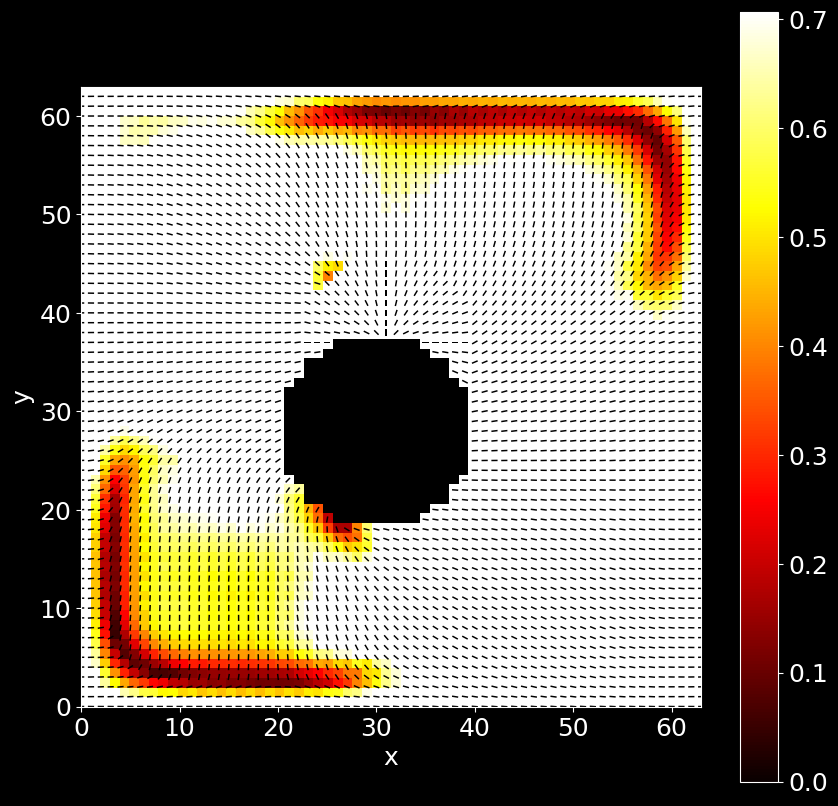

In [10]:
a=0
print(f"icx: {icx_list[a]}", f"icy: {icy_list[a]}", f"R: {R_list[a]}", f"anchoring_type: {anchoring_type_list[a]}", f"inclusion: {inclusion_list[a]}", f"anchoring_direction: {anchoring_direction_list[a]}")
index = np.where(Mask_input[a,1,:,:] != 0)

S = np.where(Mask_input[a,1,:,:] != 0, S, np.nan)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
ax.quiver(x[index], y[index], nx[index], ny[index], color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
# circle = plt.Circle((icx_list[sel_sample], icy_list[sel_sample]), R_list[sel_sample], color='white', fill=True)


